In [2]:
from result import *
%reload_ext autoreload
%autoreload 2

/hpc/home/hy190/AL_generative/result.py:287: RuntimeWarning: divide by zero encountered in divide
  SI_index = (se_raw - se_shuffle)/N1_plus_N2
/hpc/home/hy190/AL_generative/result.py:287: RuntimeWarning: invalid value encountered in divide
  SI_index = (se_raw - se_shuffle)/N1_plus_N2


In [3]:
stimuli = ['P9_TenThous', 'M4', 'Bol', 'Ctl', 'DatExt', 'Far', 'Ger', 'Iso', 
           'Lin', 'M2', 'M3', 'M5', 'P9_Ten', 'M6', 'Mal', 'Myr', 'Ner', 'P3', 
           'P4', 'P5', 'P9', 'P9_Hund', 'Bea']

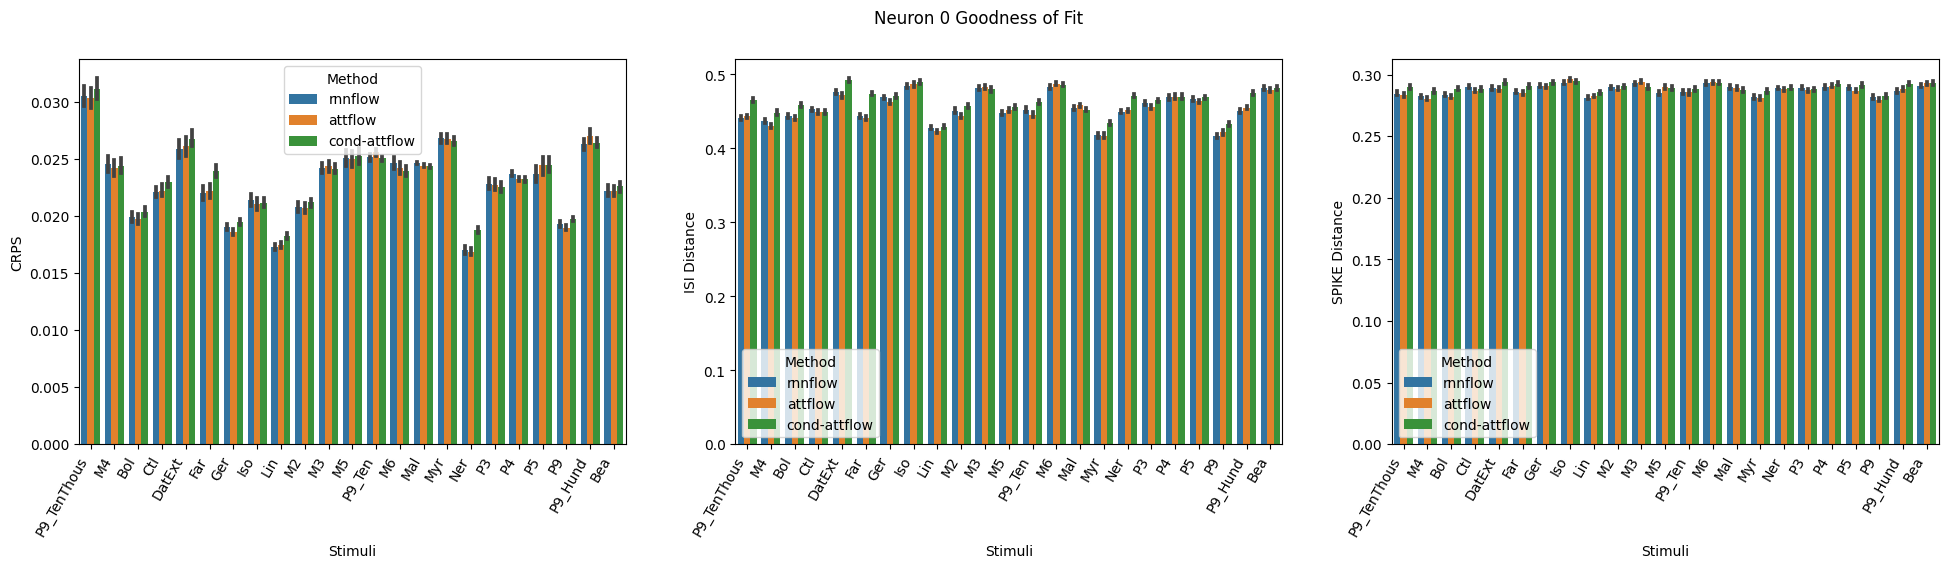

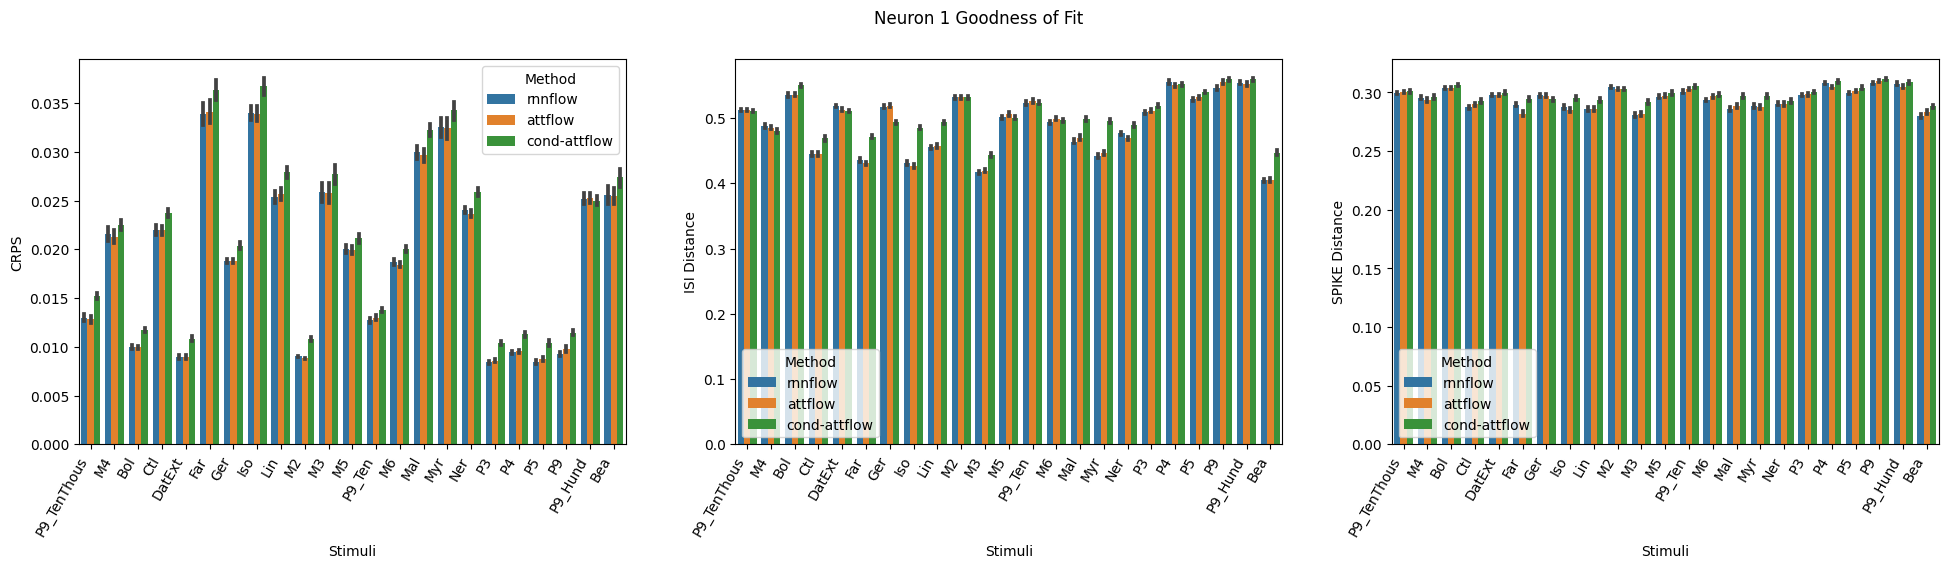

In [5]:
for target in range(0,2):
    rnn_crps_stack, rnn_isi_stack, rnn_spike_stack = analyze_noncond_stim("config/rnnflow/rnnflow-{}.yaml".format(target), 
                                                                         verbose=False)
    att_crps_stack, att_isi_stack, att_spike_stack = analyze_noncond_stim(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), 
                                                                         verbose=False)
    attcond_crps_stack, attcond_isi_stack, attcond_spike_stack = analyze_cond_stim(yaml_filepath="config/attflow.yaml", target=target, 
                                                                         verbose=False)
    plot_result_bar([rnn_crps_stack, att_crps_stack, attcond_crps_stack],
                [rnn_isi_stack, att_isi_stack, attcond_isi_stack],
                [rnn_spike_stack, att_spike_stack, attcond_spike_stack],
                target, method=["rnnflow", "attflow", "cond-attflow"])

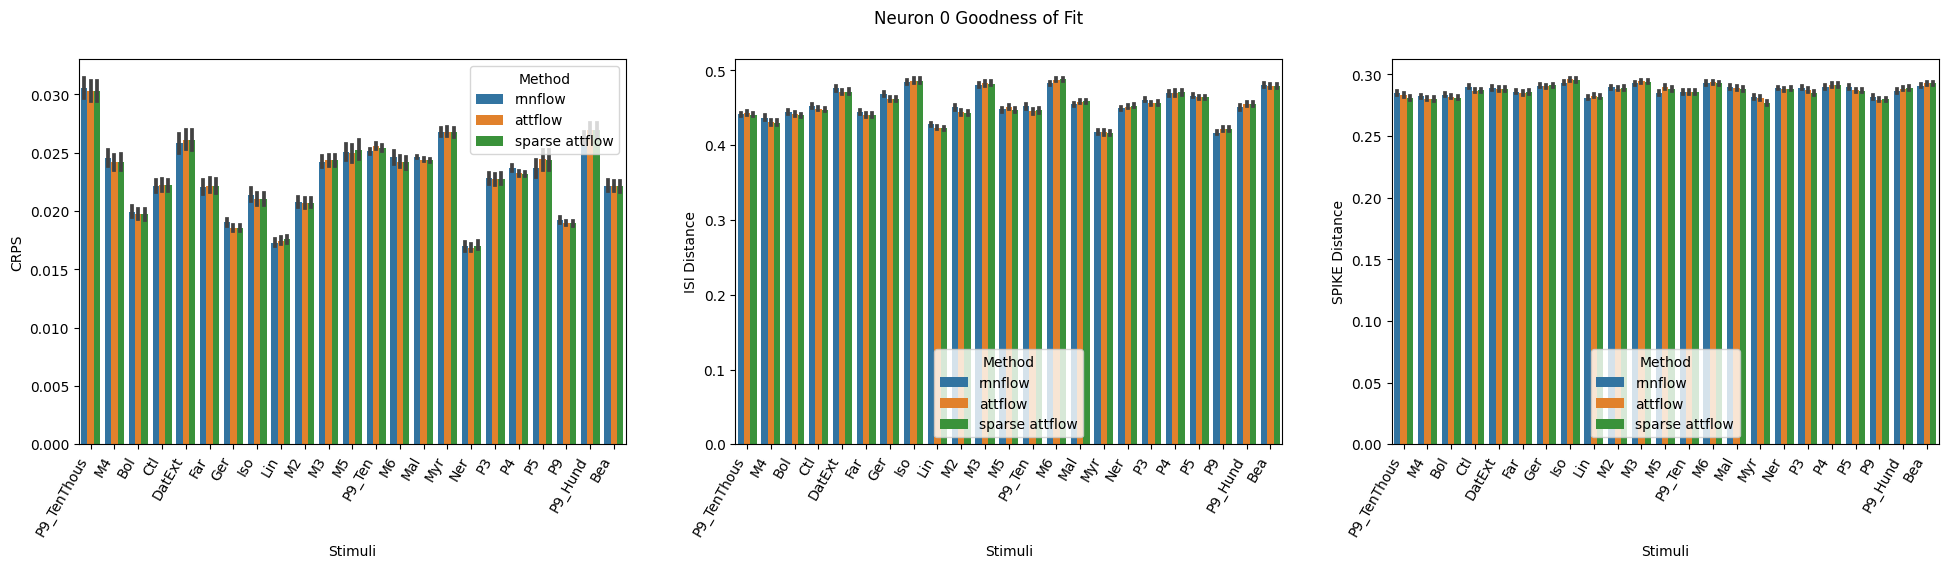

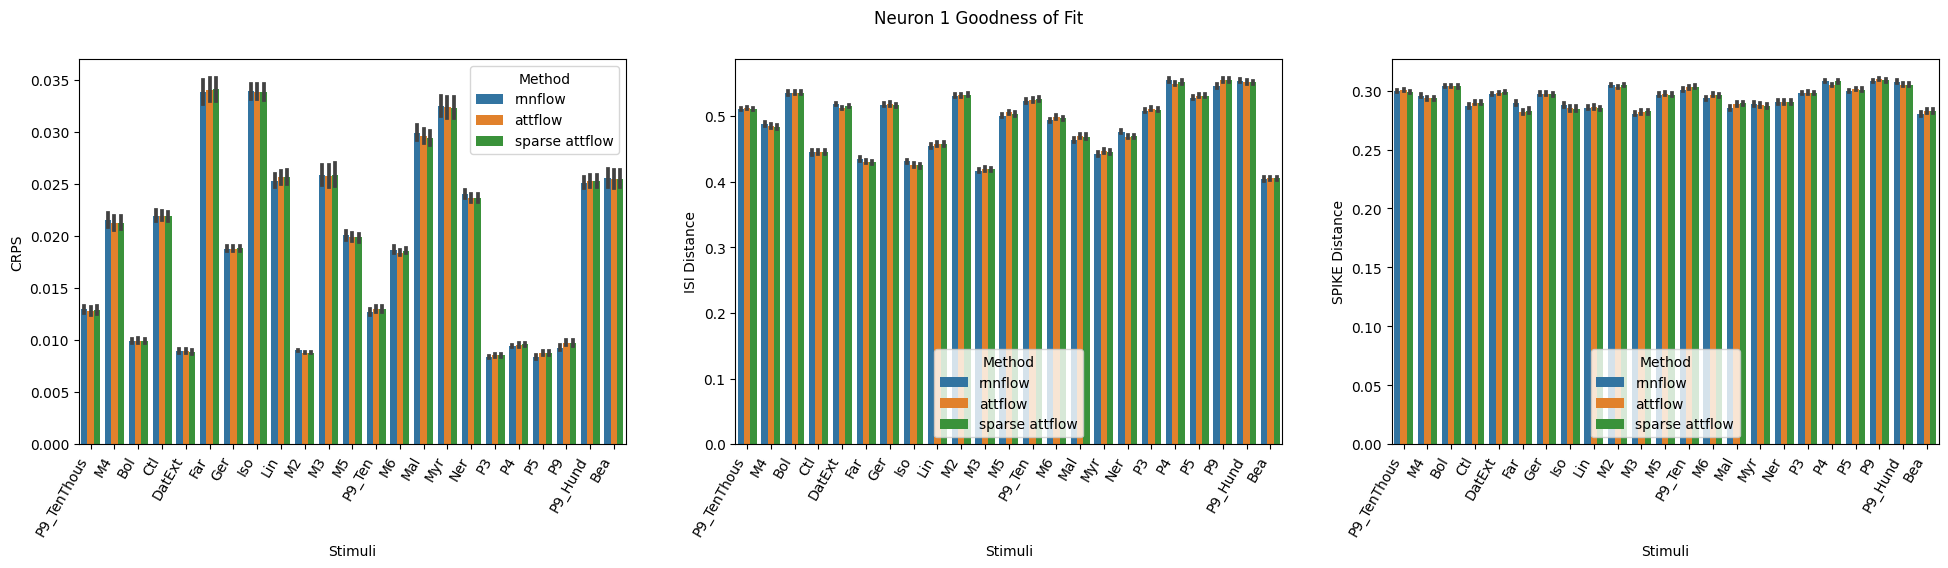

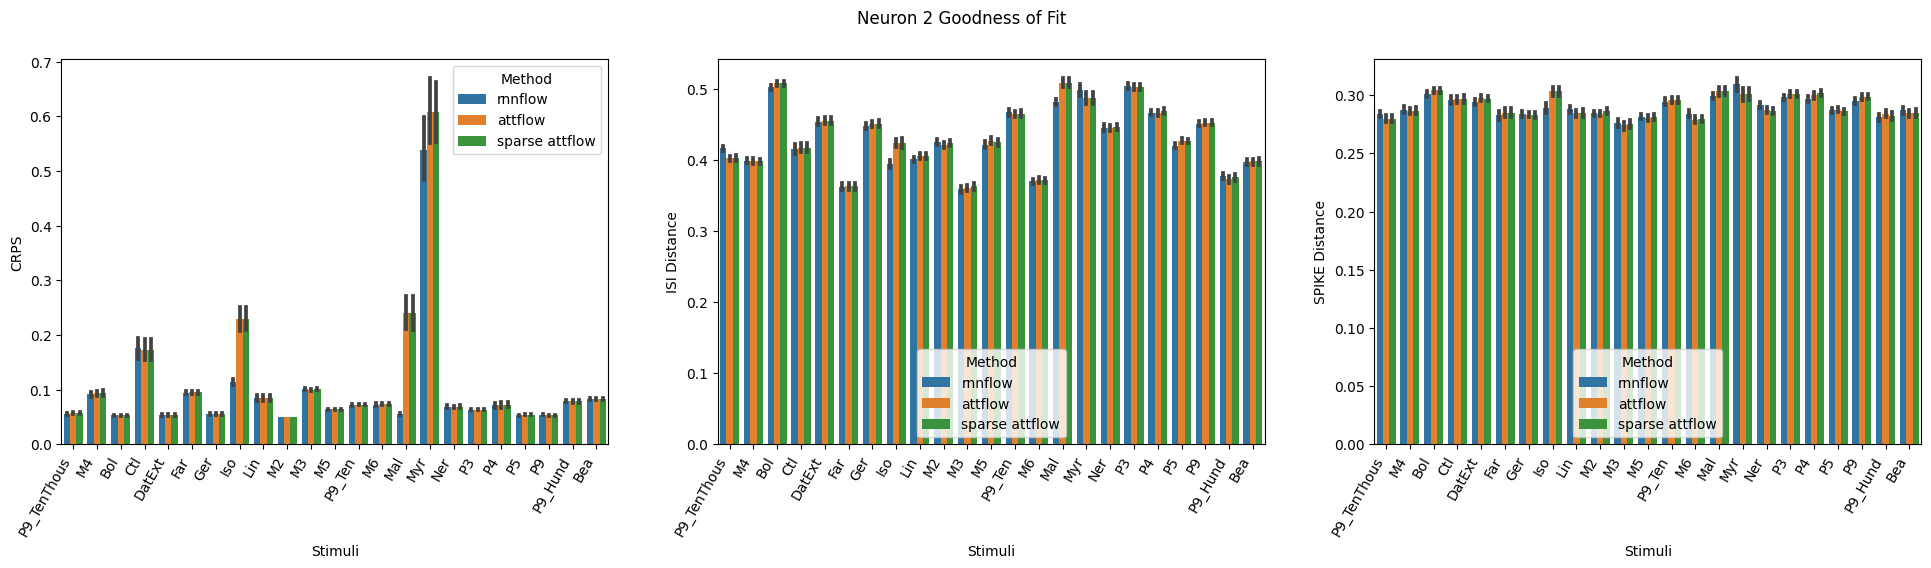

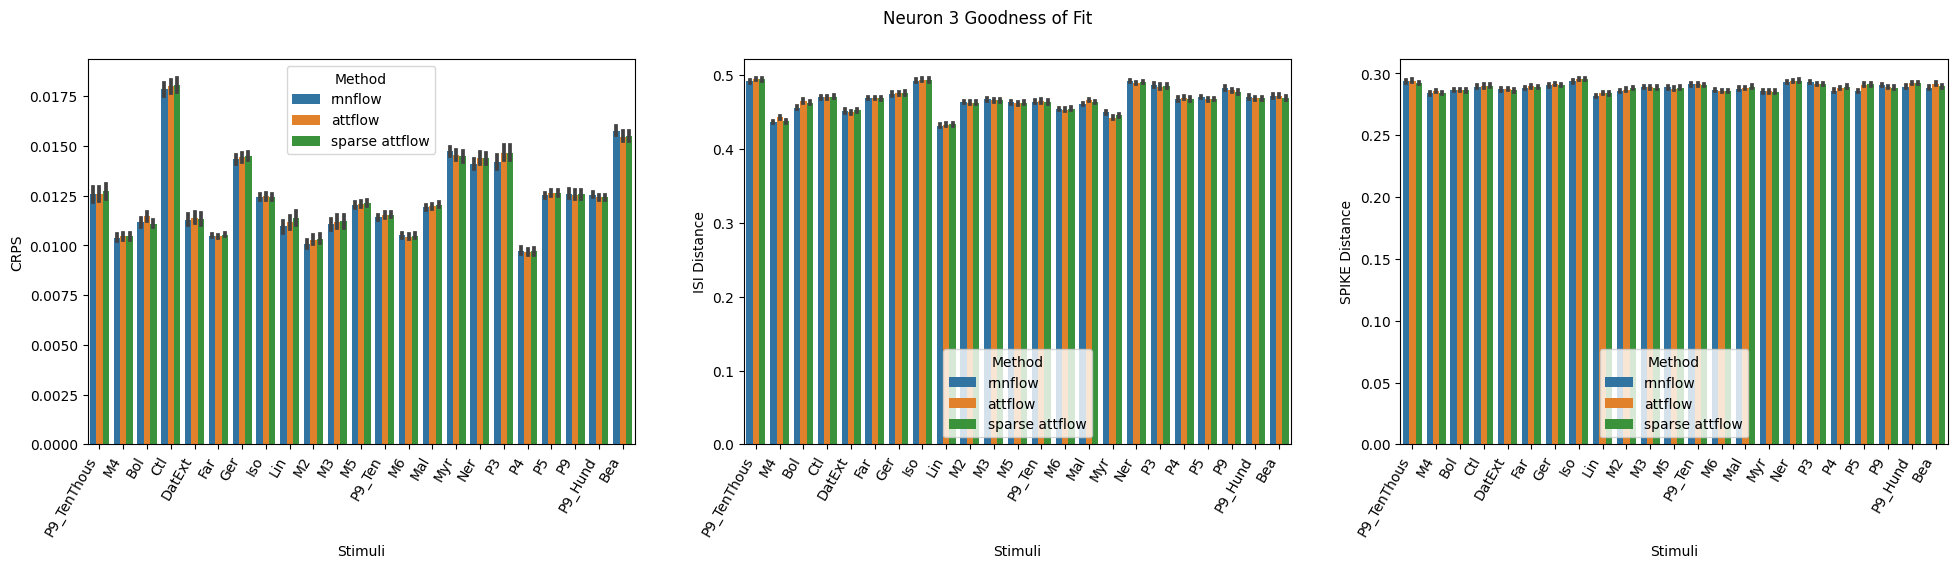

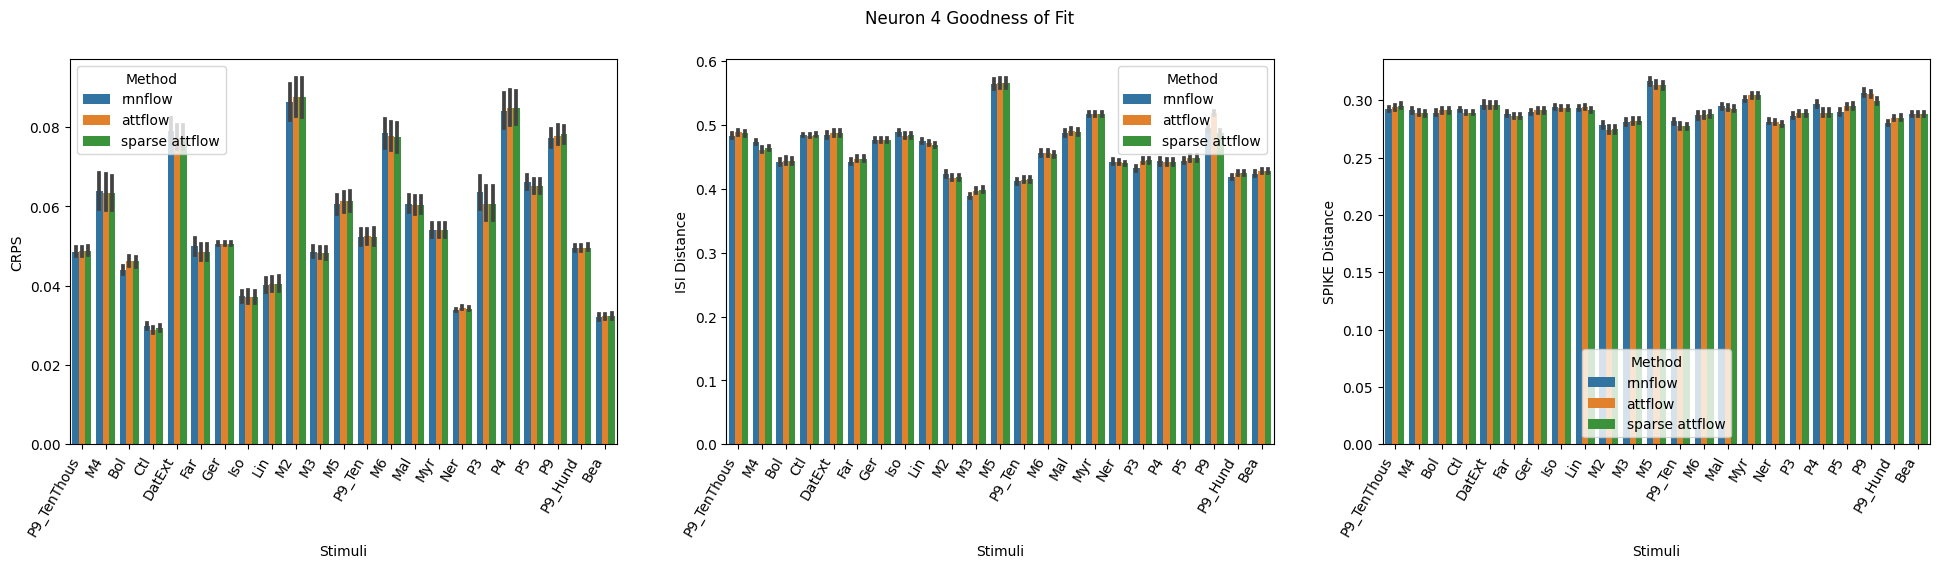

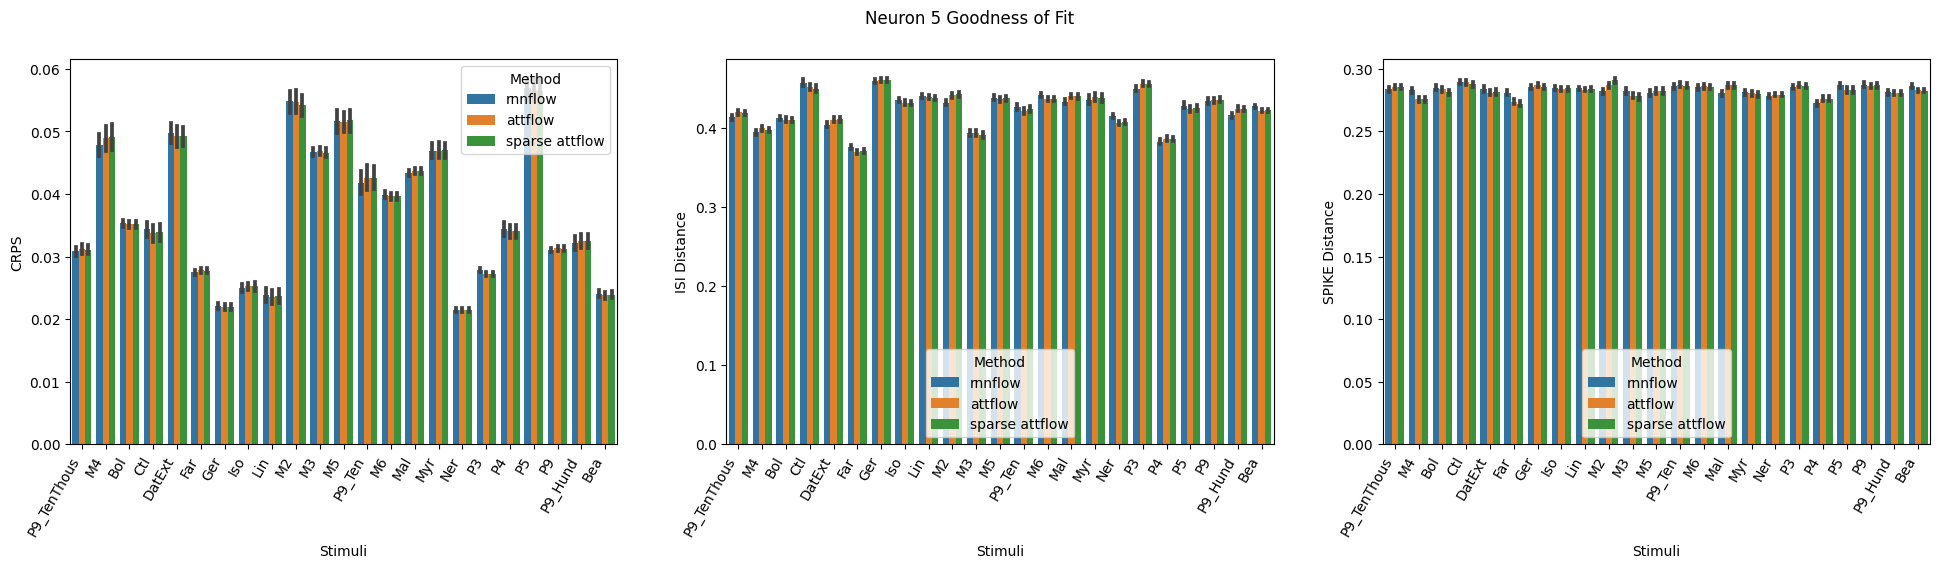

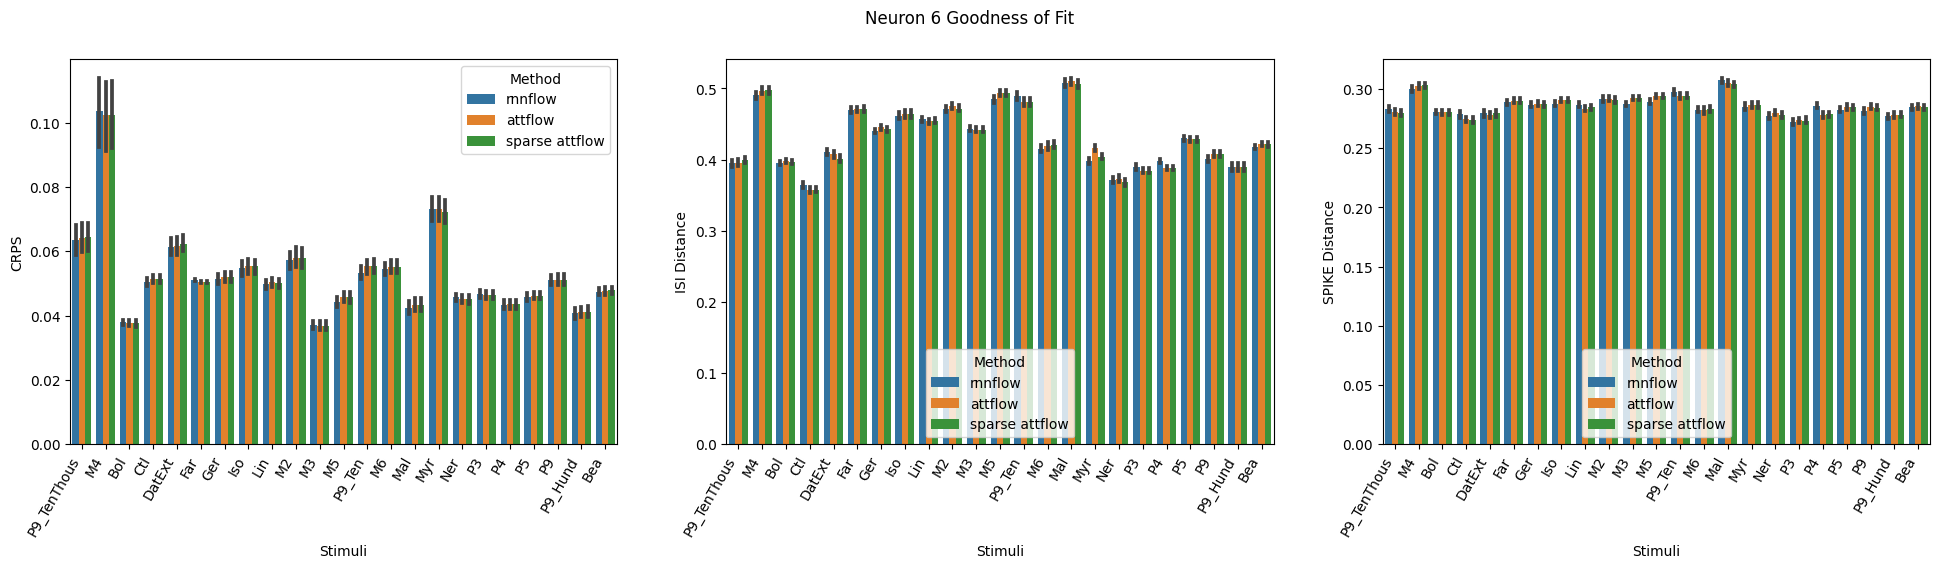

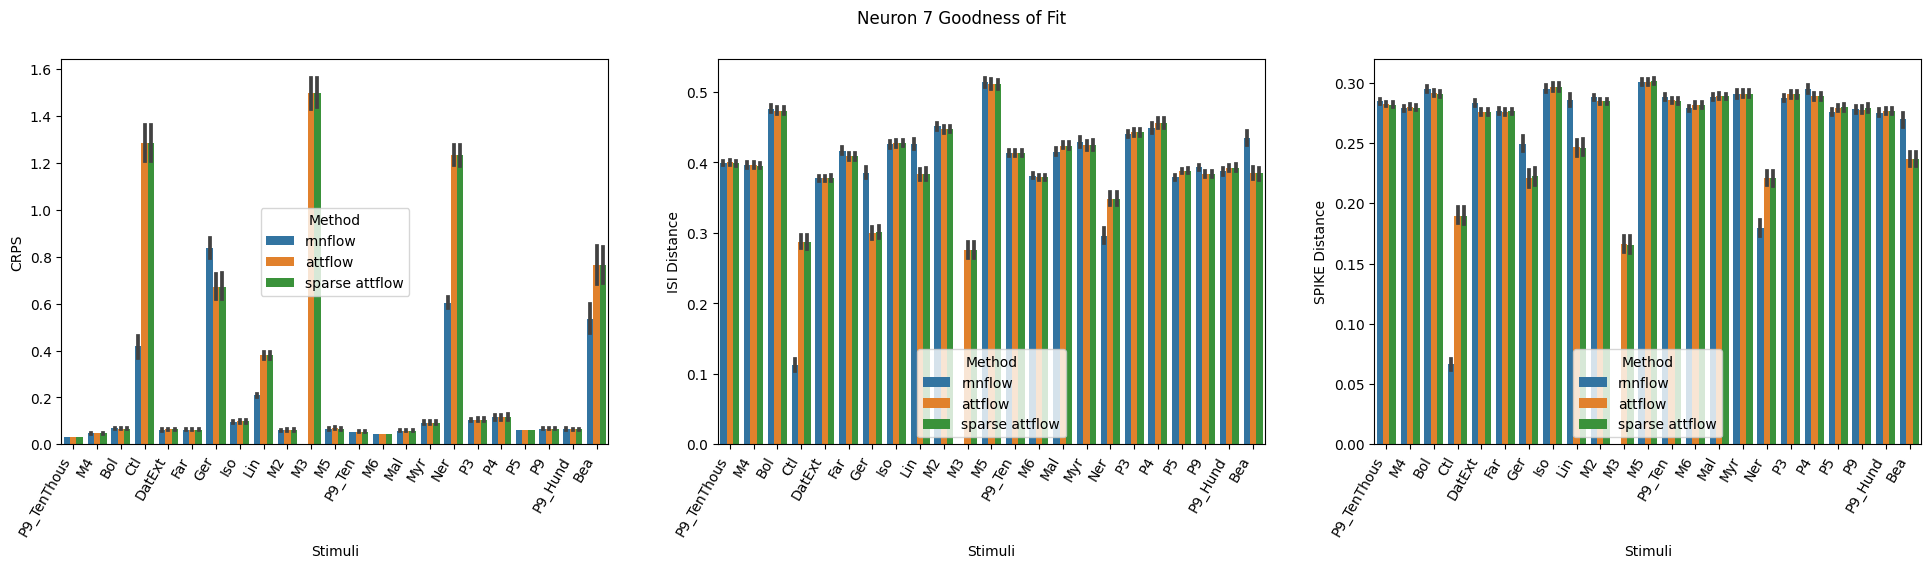

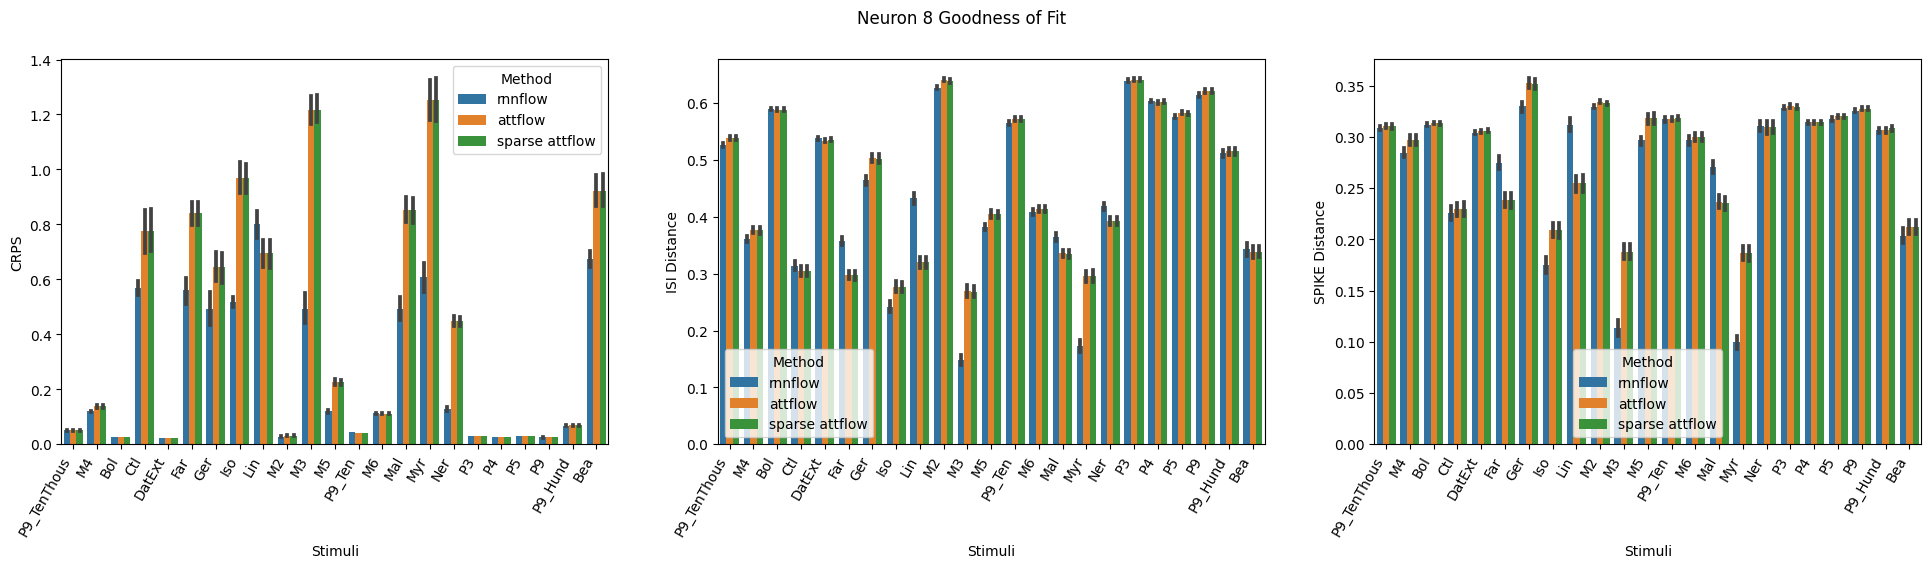

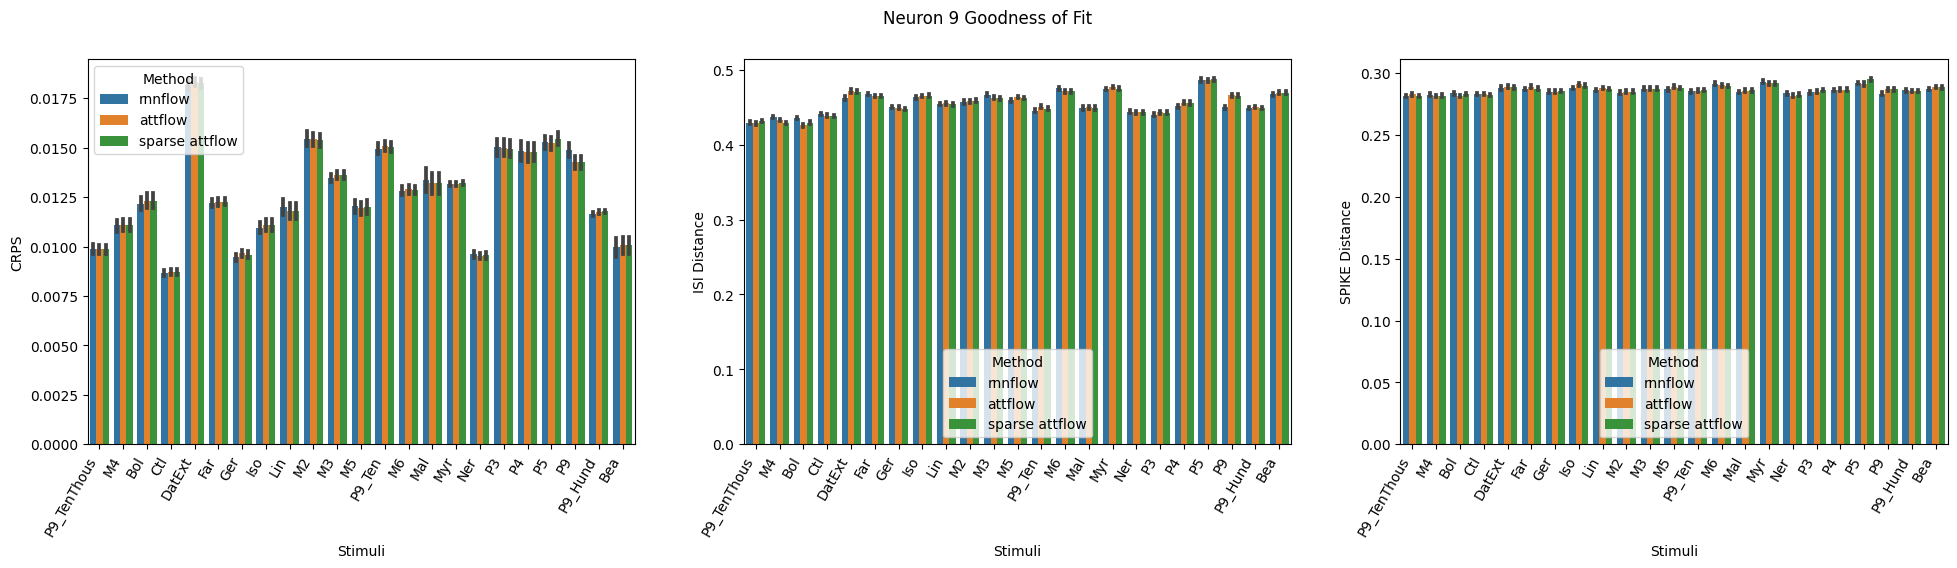

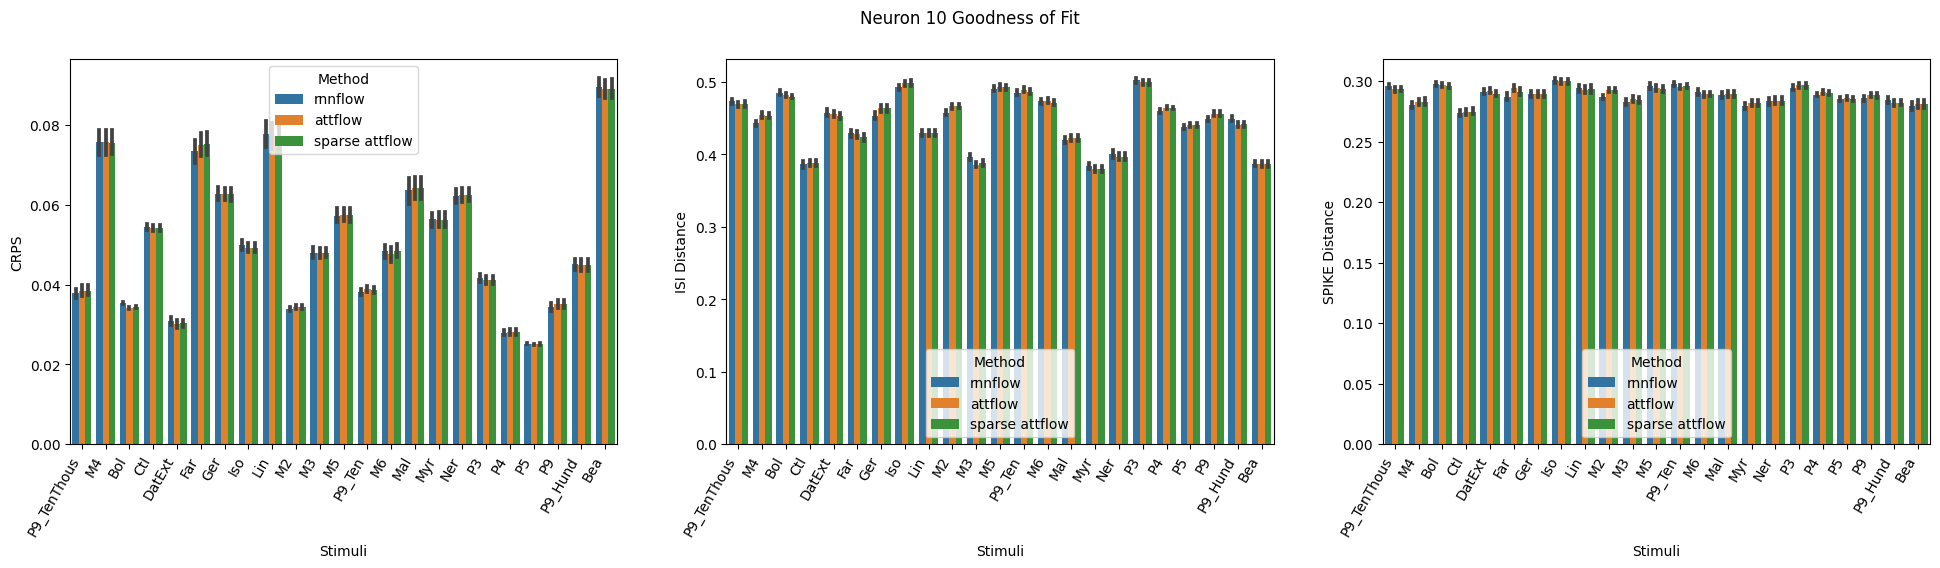

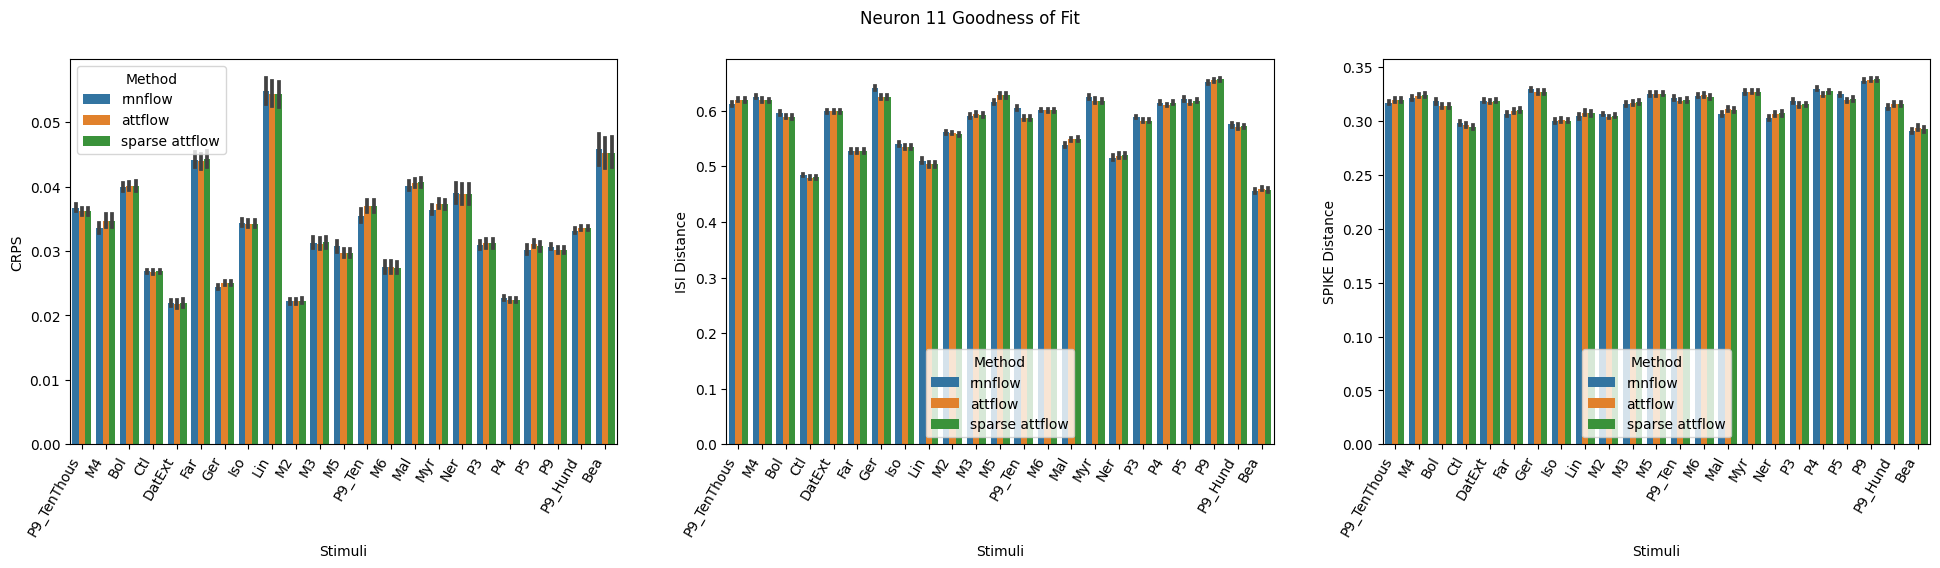

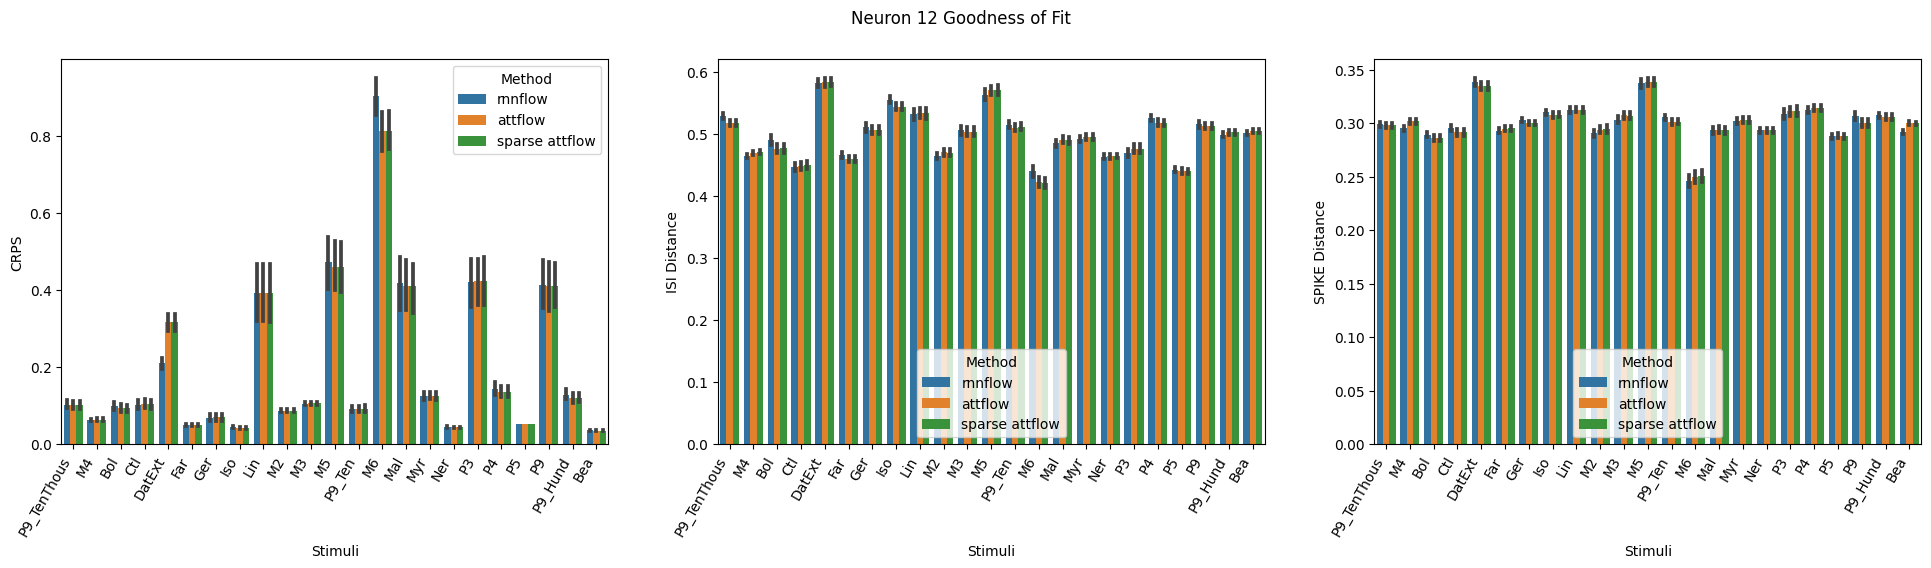

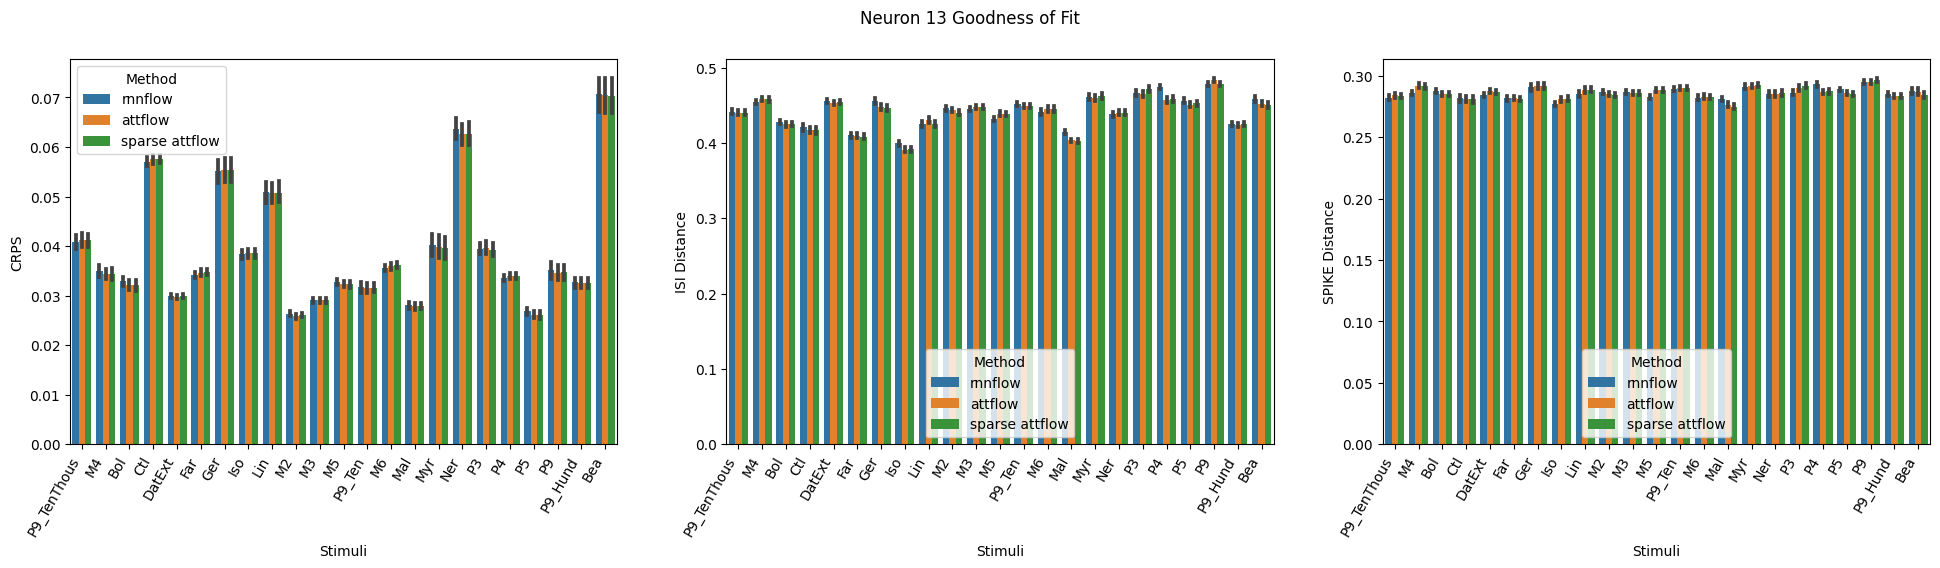

In [5]:
for target in range(0,14):
    rnn_crps_stack, rnn_isi_stack, rnn_spike_stack = analyze_noncond_stim("config/rnnflow/rnnflow-{}.yaml".format(target), 
                                                                         verbose=False)
    att_crps_stack, att_isi_stack, att_spike_stack = analyze_noncond_stim(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), 
                                                                       verbose=False)
    spa_crps_stack, spa_isi_stack, spa_spike_stack = analyze_noncond_stim(yaml_filepath="config/sparse-attflow/sparse-attflow-{}.yaml".format(target), 
                                                                       verbose=False)
    plot_result_bar([rnn_crps_stack, att_crps_stack,spa_crps_stack],
                [rnn_isi_stack, att_isi_stack,spa_isi_stack],
                [rnn_spike_stack, att_spike_stack, spa_spike_stack],
                target, method=["rnnflow", "attflow", "sparse attflow"])

In [2]:
import pandas as pd
import numpy as np
import json

In [65]:
path="/hpc/group/tarokhlab/hy190/data/AL/ALdata/070921_cleaned.csv"
df = pd.read_csv(path, index_col=0)
neurons = list(df.keys())[2:]
for i in range(df.shape[0]):
    for j in neurons:
        df.at[i,j] = np.round(json.loads(df.iloc[i][j]), 3)
all_stimuli_count = df.value_counts("stimuli").to_dict()
num_stimuli = len(all_stimuli_count)
bins = np.arange(0,1,0.005)
SI_index_by_stimuli = []
mean_SI_index_by_stimuli = []
for s_index, s in enumerate(all_stimuli_count):
    SI_index_list = []
    for run in range(all_stimuli_count[s]):
        # SE Raw
        se_raw = np.zeros((len(neurons), len(neurons)))
        se_shuffle = np.zeros((len(neurons), len(neurons)))
        N1_plus_N2 = np.zeros((len(neurons), len(neurons)))
        data_stimuli = df[df["stimuli"] == s]
        data_concat = np.zeros((1000,len(neurons)))
        for j, neuron_1 in enumerate(neurons):
            neuron_tar = data_stimuli.iloc[run][neuron_1]
            neuron_tar_low = neuron_tar - 0.01
            neuron_tar_high = neuron_tar + 0.01
            
            neuron_tar_low = neuron_tar_low
            neuron_tar_high = neuron_tar_high
            for k, neuron_2 in enumerate(neurons):
                # SE Raw
                neuron_ref = data_stimuli.iloc[run][neuron_2]
                coinci_event = np.zeros((5,))
                for range_tuple in zip(neuron_tar_low, neuron_tar_high):
                    hist, _ = np.histogram(neuron_ref, bins=5, range=range_tuple)
                    coinci_event += hist
                
                #within_range = low_leq*high_geq
                se_raw[j,k] = coinci_event.sum()
                

                # N1 + N2
                N1_plus_N2[j,k] = neuron_tar.sum() + neuron_ref.sum()
                # SE Shuffle
                for shift_predictor_run in range(all_stimuli_count[s]):
                    if shift_predictor_run == run:
                        continue
                    shuf_neuron_ref = data_stimuli.iloc[shift_predictor_run][neuron_2]
                    shuf_coinci_event = np.zeros((5,))
                    for range_tuple in zip(neuron_tar_low, neuron_tar_high):
                        shuf_hist, _ = np.histogram(shuf_neuron_ref, bins=5, range=range_tuple)
                        shuf_coinci_event += shuf_hist
        #                
        #            neuron_ref_shuffle = data_concat_shuffle[:,k]
        #            cross_corr_shuffle = correlate(neuron_ref_shuffle, neuron_tar)
        #            cross_cor_lags = correlation_lags(len(neuron_ref_shuffle), len(neuron_tar))
                    se_shuffle[j,k] += shuf_coinci_event.sum()#cross_corr_shuffle[np.where((cross_cor_lags <= 5) & (cross_cor_lags >= -5))].sum()
        
                if k == 4:
                    break
            break
        break              
        #se_shuffle = se_shuffle/(all_stimuli_count[s] - 1)
        #SI_index = (se_raw - se_shuffle)/N1_plus_N2
        #SI_index_list.append(SI_index) 
    #mean_SI_index_by_stimuli.append(np.mean(SI_index_list, 0))
    #SI_index_by_stimuli.append(SI_index_list)

In [63]:
coinci_event


array([5., 3., 3., 9., 9.])

In [64]:
shuf_coinci_event

array([3., 4., 3., 4., 4.])

In [53]:
neuron_tar

array([0.041, 0.078, 0.098, 0.114, 0.171, 0.188, 0.211, 0.33 , 0.341,
       0.389, 0.428, 0.437, 0.447, 0.456, 0.462, 0.551, 0.559, 0.611,
       0.615, 0.636, 0.682, 0.703, 0.763, 0.822, 0.868, 0.924, 0.966,
       0.988, 0.993, 0.998])

In [153]:
(np.where((cross_cor_lags >= -5) & (cross_cor_lags <= 5)))
cross_corr[np.where(cross_cor_lags == 0)]

array([8.])

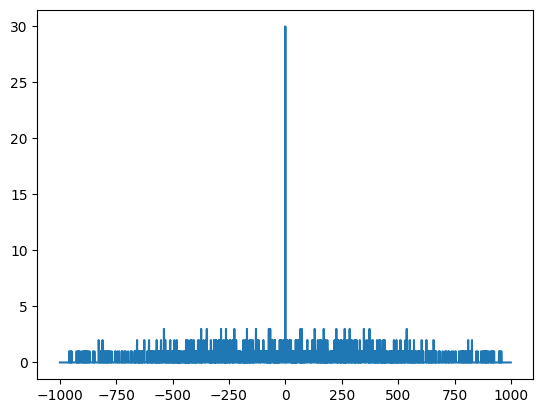

In [132]:
import matplotlib.pyplot as plt
plt.plot(cross_cor_lags, cross_corr)

In [ ]:
import pandas as pd
pd.read_csv()